# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [1]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package brown to
[nltk_data]     /Users/ivanilicev/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
COVERAGE_THRESHOLD = 0.9

In [3]:
brown_words = brown.words()
len(brown_words)

1161192

In [4]:
len(set(brown_words))

56057

In [5]:
counter = Counter(brown_words)

In [6]:
counter

Counter({'the': 62713,
         ',': 58334,
         '.': 49346,
         'of': 36080,
         'and': 27915,
         'to': 25732,
         'a': 21881,
         'in': 19536,
         'that': 10237,
         'is': 10011,
         'was': 9777,
         'for': 8841,
         '``': 8837,
         "''": 8789,
         'The': 7258,
         'with': 7012,
         'it': 6723,
         'as': 6706,
         'he': 6566,
         'his': 6466,
         'on': 6395,
         'be': 6344,
         ';': 5566,
         'I': 5161,
         'by': 5103,
         'had': 5102,
         'at': 4963,
         '?': 4693,
         'not': 4423,
         'are': 4333,
         'from': 4207,
         'or': 4118,
         'this': 3966,
         'have': 3892,
         'an': 3542,
         'which': 3540,
         '--': 3432,
         'were': 3279,
         'but': 3007,
         'He': 2982,
         'her': 2885,
         'one': 2873,
         'they': 2773,
         'you': 2766,
         'all': 2726,
         'would': 26

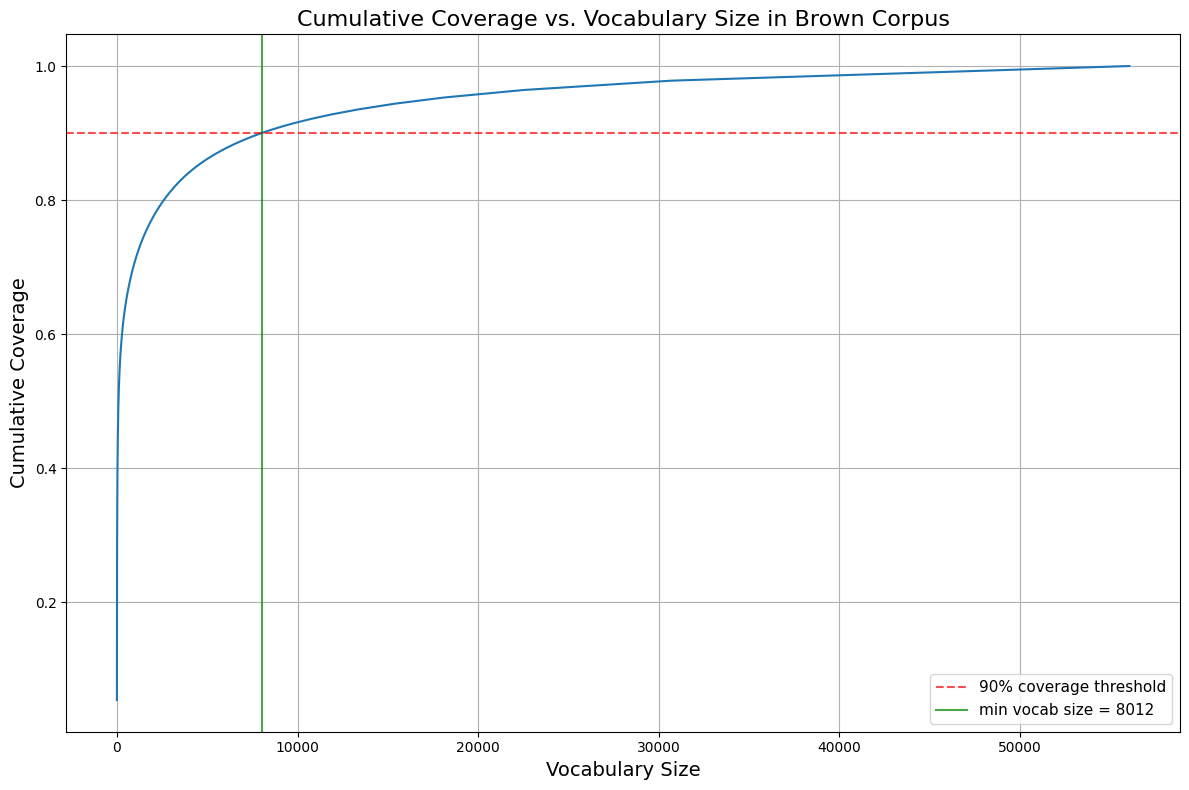

Minimum vocabulary size for >= 90% coverage: 8012
Coverage at chosen minimal vocablary size 8012: 0.900005
Total number of unique words in the Brown corpus: 56057


In [7]:
counter = Counter(brown_words)
frequencies = sorted(counter.values(), reverse=True)
frequencies_sum = sum(counter.values())
cumulative_frequencies = np.cumsum(frequencies)
cumulative_coverage = cumulative_frequencies / frequencies_sum

plt.figure(figsize=(12, 8))
plt.plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage, linewidth=1.5)
plt.xlabel('Vocabulary Size', fontsize=14)
plt.ylabel('Cumulative Coverage', fontsize=14)
plt.title('Cumulative Coverage vs. Vocabulary Size in Brown Corpus', fontsize=16)
plt.axhline(y=COVERAGE_THRESHOLD, color='r', linestyle='--', alpha=0.7, label='90% coverage threshold')

# Find the minimal vocabulary size achieving 90% of the coverage
min_vocab_size = int(np.argmax(cumulative_coverage >= COVERAGE_THRESHOLD)) + 1 # +1 for 1-based indexing
plt.axvline(x=min_vocab_size, color='g', linestyle='-', alpha=0.7, label=f'min vocab size = {min_vocab_size}')

plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Minimum vocabulary size for >= 90% coverage: {min_vocab_size}')
print(f'Coverage at chosen minimal vocablary size {min_vocab_size}: {cumulative_coverage[min_vocab_size - 1]:.6f}')
print(f'Total number of unique words in the Brown corpus: {len(counter)}')

### Answers to Task 1 Questions

**Q1: Why does the coverage slow down as the vocabulary size increases?**

As vocabulary size increases, we are adding extremely rare words to the vocabulary. The most frequent words (e.g., "the", "of", "and") constitute large volume of all word occurrences. Once these high-frequency words are included, each additional word contributes only a tiny fraction to the cumulative coverage because it appears much less frequently in the corpus. This results in slowing down of the coverage curve: it flattens as we add more words (which are rarer).

**Q2: Which empirical law explains the slowing down of coverage increase?**

**Zipf's Law** explains this behavior. It states: "When a list of measured values is sorted in decreasing order, the value of the $n$-th entry is often approximately inversely proportional to $n$". Applying to out case, the frequency of a word should be inversely proportional to its rank in the sorted frequency collection: $f(r) \propto 1/r^{\alpha}$ (where $\alpha \approx 1$). An example of the Law visualization on "War and Peace" by Tolstoy is shown on the Fugure below (source - https://commons.wikimedia.org/wiki/File:Zipf%27s_law_on_War_and_Peace.png). ![image.png](https://upload.wikimedia.org/wikipedia/commons/9/96/Zipf%27s_law_on_War_and_Peace.png)
This means a limited number of words are extremely common while the remaining majority are rare. The resulting heavy-tailed distribution directly causes the observed flattening of the cumulative coverage curve — the first few hundred words cover a large portion of the corpus, but covering the remaining fraction requires an increasingly large vocabulary.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [8]:
class BPETokenizer:
    """Byte-Pair Encoding (BPE) Tokenizer class
 
    Implements the BPE algorithm adapted to characters rather than bytes from Sennrich et al. (2016),
    "Neural Machine Translation of Rare Words with Subword Units".capitalize
    
    The tokenizer learns a vocabulary of subword units by iteratively merging the most frequent pair of adjacent symbols in the (training) corpus.
    An end-of-word token '</w>' is added to each word to indicate word boundaries.
 
    Attributes:
    vocab_size (int): Target vocabulary size.
    marges (list): Ordered list of learned (symbol_a, symbol_b) merge operations.
    vocab (set): Set of all subword tokens in the final vocabulary.
    merge_priority (dict): Mapping from merge pairs to the priority index.
    """
 
    def __init__(self, vocab_size: int):
        """Initialize BPE tokenizer with a target vocabulary size

        Args:
            vocab_size (int): Desired vocabulary size. The number of merge operations will be 'vocab_size - initial character vocabulary size'.
        """
        self.vocab_size = vocab_size
        self.merges = []           # Ordered merge operations
        self.vocab = set()         # Final vocabulary
        self.merge_priority = {}   # Pair -> priority index for fast lookup
        
    def _build_vocab_freqs(self, corpus: list[str]) -> dict[tuple, int]:
        """Build a frequency table of words represented as character tuples.
        
        Each word in converted to a tuple of individual characters with an end-of-word token '</w>' added. This indicator helps distiguish subwords at word boundaries from subwords, which reside inside words.

        Args:
            corpus (list[str]): List of words from the training corpus.
            
        Returns:
            dict: Mapping from symbol tuples (e.g., ('h', 'e', 'l', 'l', 'o', '</w>')) to their frequency counts in the corpus.
        """
        word_freqs = Counter()
        for word in corpus:
            # Represent each word as a tuple of characters + end-of-word token '</w>'
            symbols = tuple(word) + ('</w>',)
            word_freqs[symbols] += 1
        return dict(word_freqs)
    
    def _count_pairs(self, word_freqs: dict[tuple, int]) -> Counter[tuple, int]:
        """Count frequencies of all adjacent symbol pairs across the vocabulary.
        
        Each pair's frequency is weighted by the frequency of word it appears in. For example, if 'hello' appears 5 times and contains the pair ('h', 'e'), this pair gets a count of 5.

        Args:
            word_freqs (dict[tuple, int]): Mapping from symbol tuples to word frequencies.

        Returns:
            Counter[tuple, int]: Mapping from (symbol_a, symbol_b) pairs to their total weighted frequency.
        """
        pairs = Counter()
        for symbols, freq in word_freqs.items():
            # Count each adjacent pair, weighted by word frequency
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
        return pairs
    
    def _merge_pair(self, word_freqs: dict[tuple, int], pair: tuple) -> dict[tuple, int]:
        """Merge all occurences of a symbol pair in the word frequency table.
        
        Scans tthrough each word's symbol representation and replaces all adjacent occurences of the specified pair with a single merged token.

        Args:
            word_freqs (dict[tuple, int]): Current word frequency table.
            pair (tuple): The (symbol_a, symbol_b) pair to merge.

        Returns:
            dict[tuple, int]: Updated word frequency table with the pair merged.
        """
        new_word_freqs = {}
        merged_symbol = pair[0] + pair[1]
        
        for symbols, freqs in word_freqs.items():
            new_symbols = []
            i = 0
            while i < len(symbols):
                # Check whether current and next symbol match the merge pair
                if (i < len(symbols) - 1 and symbols[i] == pair[0]
                and symbols[i + 1] == pair[1]):
                    # Replace the pair with the merged symbol
                    new_symbols.append(merged_symbol)
                    i += 2 # Skip both symbols
                else:
                    new_symbols.append(symbols[i])
                    i += 1
            new_word_freqs
       
        return new_word_freqs
            
    def train(self, corpus: list[str]):
        """Train the BPE tokenizer on a text corpus.
        
        Training procedure:
        1. Build a word frequency table with character-level representations
        2. Initialize vocabulary with all unique characters + '</w>' token
        3. Iteratively find and merge the most frequent adjacent symbol (token, or n-gram symbol) pair
        4. Record each merge operation for use during tokenization
        5. Stop when the target vocabulary size is reached

        Args:
            corpus (list[str]): List of words to train the tokenizer on.
        """
        # Step 1: Build word frequency table (characters + end-of-word special token)
        word_freqs = self._build_vocab_freqs(corpus)
        
        # Step 2: Initialize vocabulary with all unique characters in the corpus
        self.vocab = set()
        for symbols in word_freqs.keys():
            for s in symbols:
                self.vocab.add(s)
                
        initial_size = len(self.vocab)
        num_merges = self.vocab_size - initial_size
        
        if num_merges <= 0:
            print(f'Initial character vocabulary ({initial_size}) already meets target size ({self.vocab_size}). No merges will be performed')
            self.merge_priority = {}
            return
        
        print(f'Initial character vocabulary size: {initial_size}')
        print(f'Target vocabulary size: {self.vocab_size}')
        print(f'Number of merge operations to perform: {num_merges}')
        
        # Step 3: Iteratively merge the most frequent adjacent pair
        self.merges = []
        for step in range(num_merges):
            # Count all adjacent symbol pair frequencies
            pair_freqs = self._count_pairs(word_freqs)
            
            if not pair_freqs:
                print(f'No more pairs to merge after {step} steps')
                break
            
            # Find the most frequent pair
            best_pair = pair_freqs.most_common(1)[0][0]
            
            # Merge the best (most frequent) pair in all word representations
            word_freqs = self._merge_pair(word_freqs, best_pair)
            
            # Record the merge operation and add new symbol to the vocabulary
            self.merges.append(best_pair)
            self.vocab.add(best_pair[0] + best_pair[1])
            
            # Print progress every 500 steps
            if (step + 1) % 500 == 0 or step == num_merges - 1:
                print(f"Merge {step + 1}/{num_merges}: "
                      f"'{best_pair[0]}' + '{best_pair[1]}' "
                      f"-> '{best_pair[0] + best_pair[1]}'")
                
        # Step 4: Build merge priority lookup for efficient tokenization
        self.merge_priority = {pair: i for i, pair in enumerate(self.merges)}
        
        print(f'\nTraining complete. Final vocabulary size: {len(self.vocab)}')
        
    def tokenize(self, text: str) -> list[str]:
        """Tokenize input text into subword tokens using learned BPE merges.
        
        Tokenization procedure:
        1. Pre-tokenize: split text into words by whitespaces
        2. For each word, convert to characters + '</w>' end-of-word special token
        3. Iteratively apply the highest-priority applicable merge
        4. Collect and return all resulting subword tokens

        Args:
            text (str): Input text to tokenize.

        Returns:
            list[str]: List of subword tokens (including '</w>' ones).
        """
        # Pre-tokenization: split by whitespaces
        words = text.strip().split()
        if not words:
            return []
        
        all_tokens = []
        for word in words:
            if not word: 
                continue
            
            # Convert word to character-level representation + end-of-word token added
            symbols = list(word) + ['</w>']
            
            # Iteratively apply the highest-priority (eariest learned) merge
            while len(symbols) > 1:
                # Find the adjacent pair with the highest priority (lowest index)
                best_pair = None
                best_priority = float('inf')
                
                for i in range(len(symbols) - 1):
                    pair = (symbols[i], symbols[i + 1])
                    if (pair in self.merge_priority
                        and self.merge_priority[pair] < best_priority):
                        best_pair = pair
                        best_priority = self.merge_priority[pair]
                        
                if best_pair is None:
                    break   # No possible merge is found
                
                # Apply the merge: replace all occurences of the best pair
                merged = best_pair[0] + best_pair[1]
                new_symbols = []
                i = 0
                while i < len(symbols):
                    if (i < len(symbols) - 1
                        and symbols[i] == best_pair[0]
                        and symbols[i + 1] == best_pair[1]):
                        new_symbols.append(merged)
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                symbols = new_symbols
                
            all_tokens.extend(symbols)
            
        return all_tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [9]:
import time
from tqdm import tqdm

# Part 1: Train the BPETokenizer with the selected above vocabulary size
print(f'Training the BPE Tokenizer with vocabulary size = {min_vocab_size}\n')

tokenizer = BPETokenizer(vocab_size=min_vocab_size)

start_time = time.time()

tokenizer.train(list(brown_words))

elapsed = time.time() - start_time
print(f'Training time: {elapsed:.2f} seconds')

# Part 2: calculate statistics on 1000 Brown corpus sentences
print('Analyzing tokenizer on 1000 Brown corpus sentences')

brown_sents = brown.sents()

fertilities = []
token_lengths = []

for i, sent in tqdm(enumerate(brown_sents)):
    num_words = len(sent)
    
    # Join words into a single string and tokenize
    words_string = ' '.join(sent)
    tokens = tokenizer.tokenize(words_string)
    num_tokens = len(tokens)
    
    # Fertility: average number of subword tokens per word
    fertility = num_tokens / num_words if num_tokens > 0 else 0
    fertilities.append(fertility)
    token_lengths.append(num_tokens)

Training the BPE Tokenizer with vocabulary size = 8012

Initial character vocabulary size: 84
Target vocabulary size: 8012
Number of merge operations to perform: 7928
No more pairs to merge after 1 steps

Training complete. Final vocabulary size: 85
Training time: 0.81 seconds
Analyzing tokenizer on 1000 Brown corpus sentences


57340it [00:01, 51000.71it/s]


In [11]:
# Demonstrate collected statistic
print('Results:\n')
print('Tokenizer Fertility (subword tokens per word):')
print(f'\tMean: {np.mean(fertilities):.4f}')
print(f'\tStd: {np.std(fertilities):.4f}')
print('\nTokenized Sentence Length (number of tokens):')
print(f'\tMean: {np.mean(token_lengths):.4f}')
print(f'\tStd: {np.std(token_lengths):.4f}')

Results:

Tokenizer Fertility (subword tokens per word):
	Mean: 4.9940
	Std: 0.9161

Tokenized Sentence Length (number of tokens):
	Mean: 103.3183
	Std: 70.8446


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.